In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io, color, filters, feature, measure
import pyclesperanto_prototype as cle
from scipy import ndimage as ndi
from scipy import stats
import pandas as pd

In [2]:
import os
import re

In [3]:
img_path = "./data_04_04/images/"
msk_path = "./data_04_04/masks/"

img_list = os.listdir(img_path)
msk_list = os.listdir(msk_path)

In [4]:
def sort_by_number(list_name):
    list_name.sort(key=lambda f: int(re.sub('\D', '', f)))
    return list_name

In [5]:
img_list = sort_by_number(img_list)
msk_list = sort_by_number(msk_list)

In [6]:
assert len(img_list) == len(msk_list)
print("Number of images: ", len(img_list))
print("Number of masks: ", len(msk_list))

Number of images:  99
Number of masks:  99


In [7]:
# Check that image position in file name is corresponding to it's position in the list
def pos_check(file_list, file_path):
    file_path = sort_by_number(os.listdir(file_path))
    for actual_name, expected_name in zip(file_list, file_path):
        if actual_name.split(" ")[1][1:3] == expected_name.split(" ")[1][1:3]:
            continue
        else:
            print("Missing name: ", actual_name)
            break
    else:
        print("All good!")

In [8]:
pos_check(img_list, img_path)

All good!


In [9]:
pos_check(msk_list, msk_path)

All good!


In [10]:
import dask.array as da

In [11]:
# images = da.array([io.imread(img_path + file_name, as_gray=True) for file_name in img_list])
# masks = da.array([io.imread(msk_path + file_name, as_gray=True) for file_name in msk_list])

In [12]:
images = np.array([io.imread(img_path + file_name, as_gray=True) for file_name in img_list])
masks = np.array([io.imread(msk_path + file_name, as_gray=True) for file_name in msk_list])

In [13]:
# Plot images and masks
def plot_images(images, masks, n=5, size=(6, 10)):
    # Use random images and masks
    idx = np.random.randint(0, images.shape[0], n)
    images = images[idx]
    masks = masks[idx]
    fig, ax = plt.subplots(n, 2, figsize=size)
    # Space between subplots
    fig.subplots_adjust(hspace=0.5)
    for i in range(n):
        ax[i, 0].set_title(f"Image {i}")
        ax[i, 0].imshow(images[i], cmap="gray")
        ax[i, 1].set_title(f"Mask {i}")
        ax[i, 1].imshow(masks[i], cmap="gray")
    plt.show()

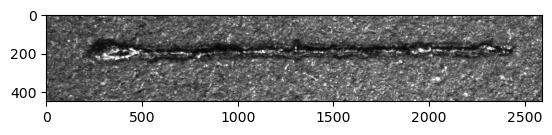

In [14]:
plt.imshow(images[90][700:1150], cmap="gray")
plt.show()

In [15]:
images_cropped = images[:, 700:1150, :]
masks_cropped = masks[:, 700:1150, :] > 0

del images, masks

### Basic statistics

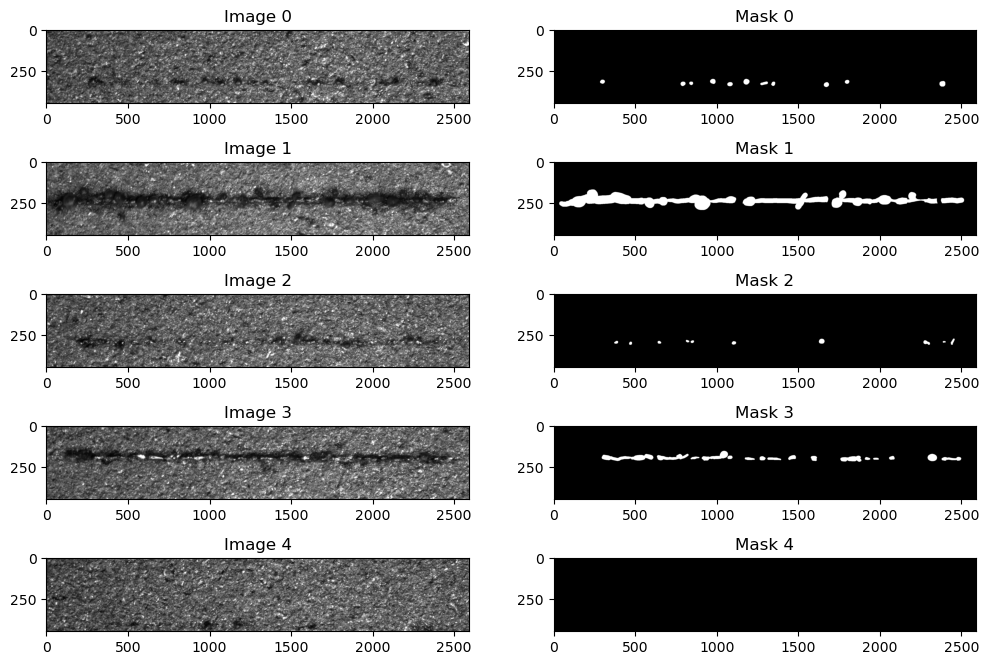

In [16]:
plot_images(images_cropped, masks_cropped, size=(12,8))

In [17]:
labels = measure.label(masks_cropped)

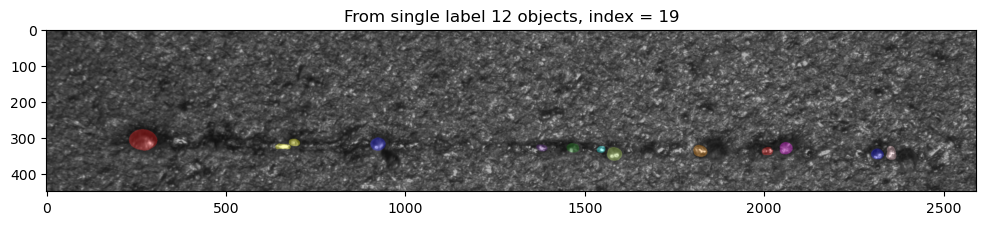

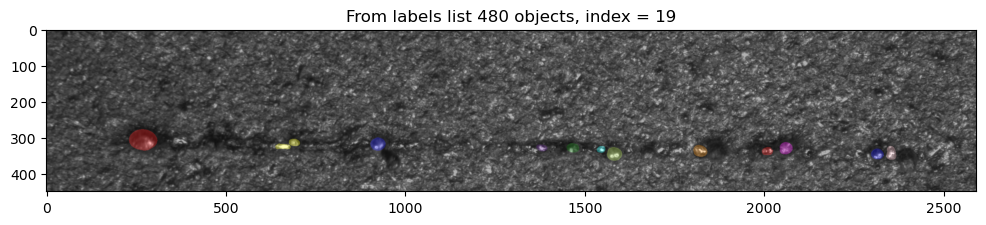

In [18]:
idx = np.random.randint(0, images_cropped.shape[0], 1)[0]
lbl = measure.label(masks_cropped[idx])
plt.figure(figsize=(12, 8))
plt.imshow(color.label2rgb(lbl, images_cropped[idx], bg_label=0))
plt.title(f"From single label {np.unique(lbl).shape[0] - 1} objects, index = {idx}")
plt.show()

rnd_inx = idx
plt.figure(figsize=(12, 8))
plt.imshow(color.label2rgb(labels[rnd_inx], images_cropped[rnd_inx], bg_label=0))
plt.title(f"From labels list {np.unique(labels).shape[0] - 1} objects, index = {rnd_inx}")
plt.show()

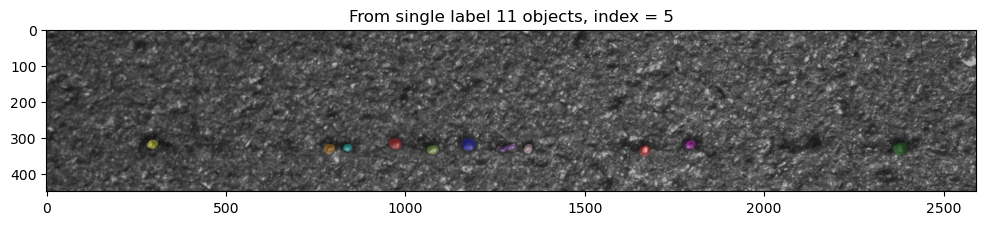

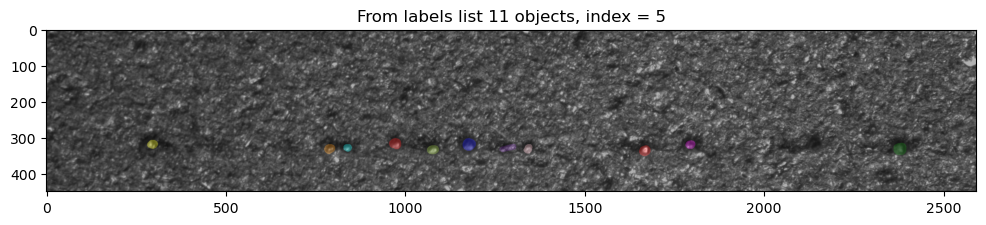

In [19]:
# Calculate labels for all cropped masks
labels = np.array([measure.label(mask) for mask in masks_cropped])

# Choose a random index
idx = np.random.randint(0, images_cropped.shape[0], 1)[0]

# Get the labeled mask for the chosen index
lbl = labels[idx]

plt.figure(figsize=(12, 8))
plt.imshow(color.label2rgb(lbl, images_cropped[idx], bg_label=0))
plt.title(f"From single label {np.unique(lbl).shape[0] - 1} objects, index = {idx}")
plt.show()

plt.figure(figsize=(12, 8))
plt.imshow(color.label2rgb(labels[idx], images_cropped[idx], bg_label=0))
plt.title(f"From labels list {np.unique(labels[idx]).shape[0] - 1} objects, index = {idx}")
plt.show()


In [20]:
continious_tracks = []
tracks_id = []
# Fill list with continious tracks
for i in range(labels.shape[0]):
    if np.unique(labels[i]).shape[0] == 2:
        continious_tracks.append(labels[i])
        tracks_id.append(i)
continious_tracks = np.array(continious_tracks)
tracks_id = np.array(tracks_id)

In [21]:
continious_tracks.shape

(16, 450, 2592)

In [22]:
tracks_id

array([52, 53, 61, 62, 67, 68, 69, 70, 71, 77, 78, 80, 89, 93, 95, 98])

In [23]:
np.random.randint(0, labels.shape[0], 5)

array([20, 70, 28,  5, 98])

In [24]:
def plot_random_labels(images, labels, label_indices, size=(8,5), num_labels=5):
    """
    Plot a random selection of labels next to their corresponding images.
    
    Args:
    - images (np.ndarray): Array of images
    - labels (np.ndarray): Array of labels
    - label_indices (np.ndarray): Array of indices corresponding to the labels in the original array
    - num_labels (int, optional): Number of labels to plot. Defaults to 5.
    """
    # Select random indices from the labels array
    random_indices = np.random.choice(labels.shape[0], size=num_labels, replace=False)
    # Space between subplots
    plt.subplots_adjust(hspace=0.5)
    # Plot the selected labels next to their corresponding images
    fig, axs = plt.subplots(nrows=num_labels, ncols=2, figsize=size)
    # Put main title at the top
    fig.suptitle(f"Random selection of {num_labels} from {len(label_indices)} labels", fontsize=16)
    for i, idx in enumerate(random_indices):
        # Find the corresponding image index in the label_indices array
        image_idx = label_indices[idx]

        # Plot the image
        axs[i, 0].imshow(images[image_idx], cmap="gray")
        axs[i, 0].set_title(f"Image {image_idx}")
        axs[i, 0].axis('off')

        # Plot the corresponding label
        axs[i, 1].imshow(color.label2rgb(labels[idx], images[image_idx], bg_label=0), cmap="gray")
        axs[i, 1].set_title(f"Label {image_idx}, objects: {np.unique(labels[idx]).shape[0] - 1}")
        axs[i, 1].axis('off')

    plt.tight_layout()

<Figure size 640x480 with 0 Axes>

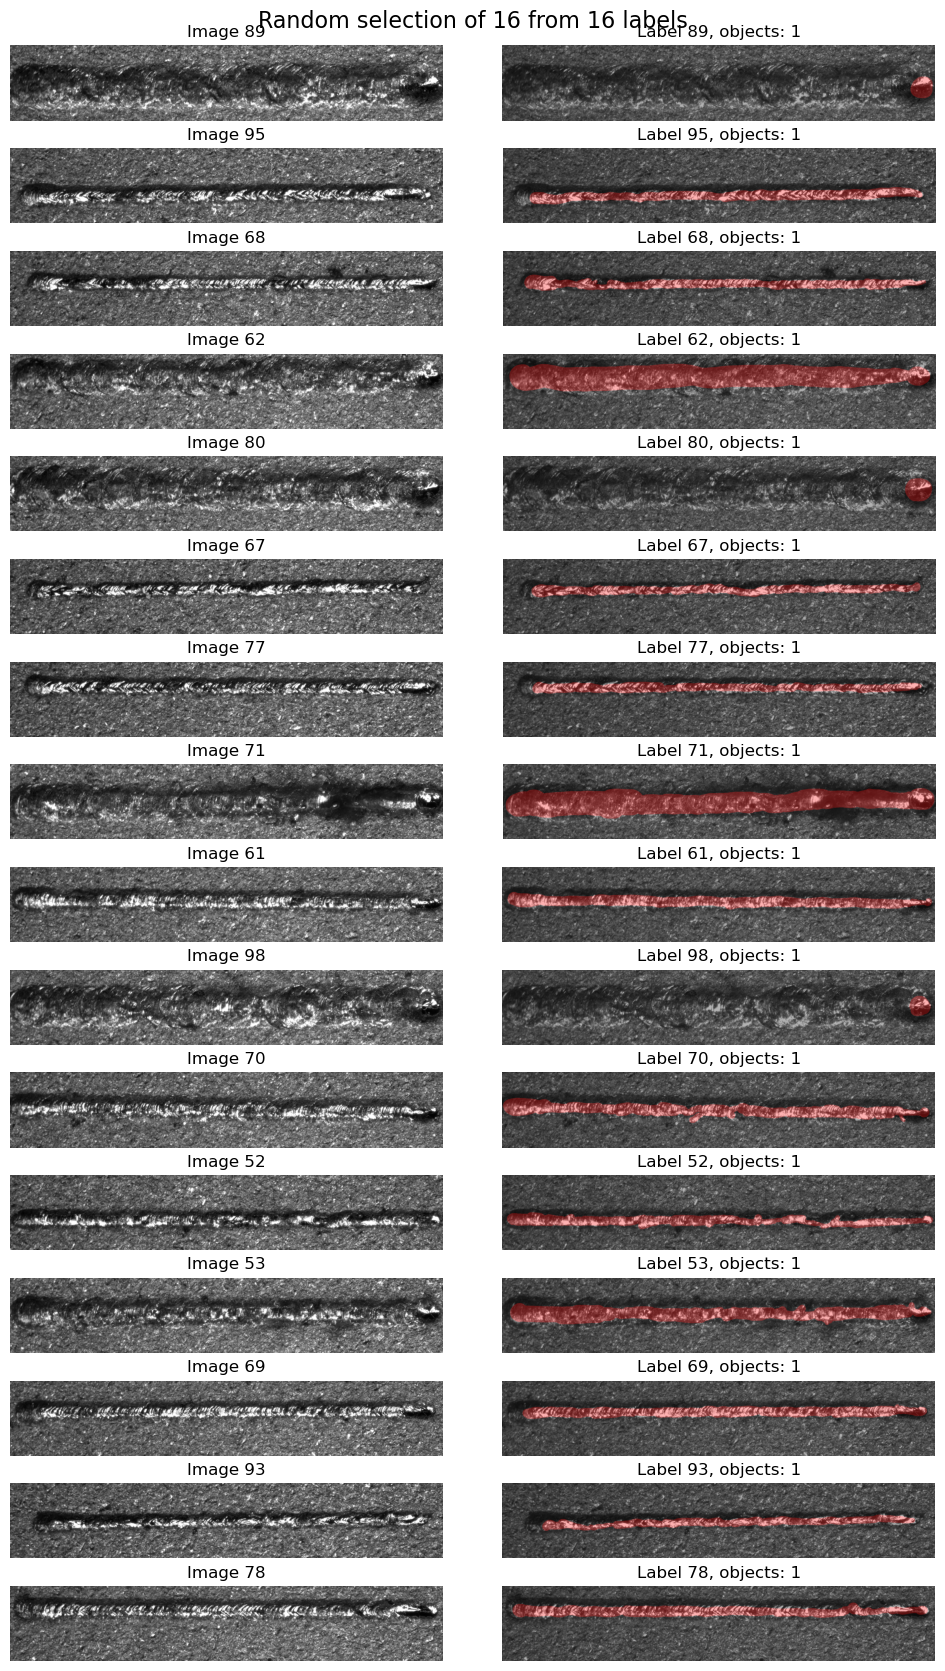

In [25]:
plot_random_labels(images_cropped, continious_tracks, tracks_id, num_labels=16, size=(10, 17))

In [26]:
continious_tracks[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

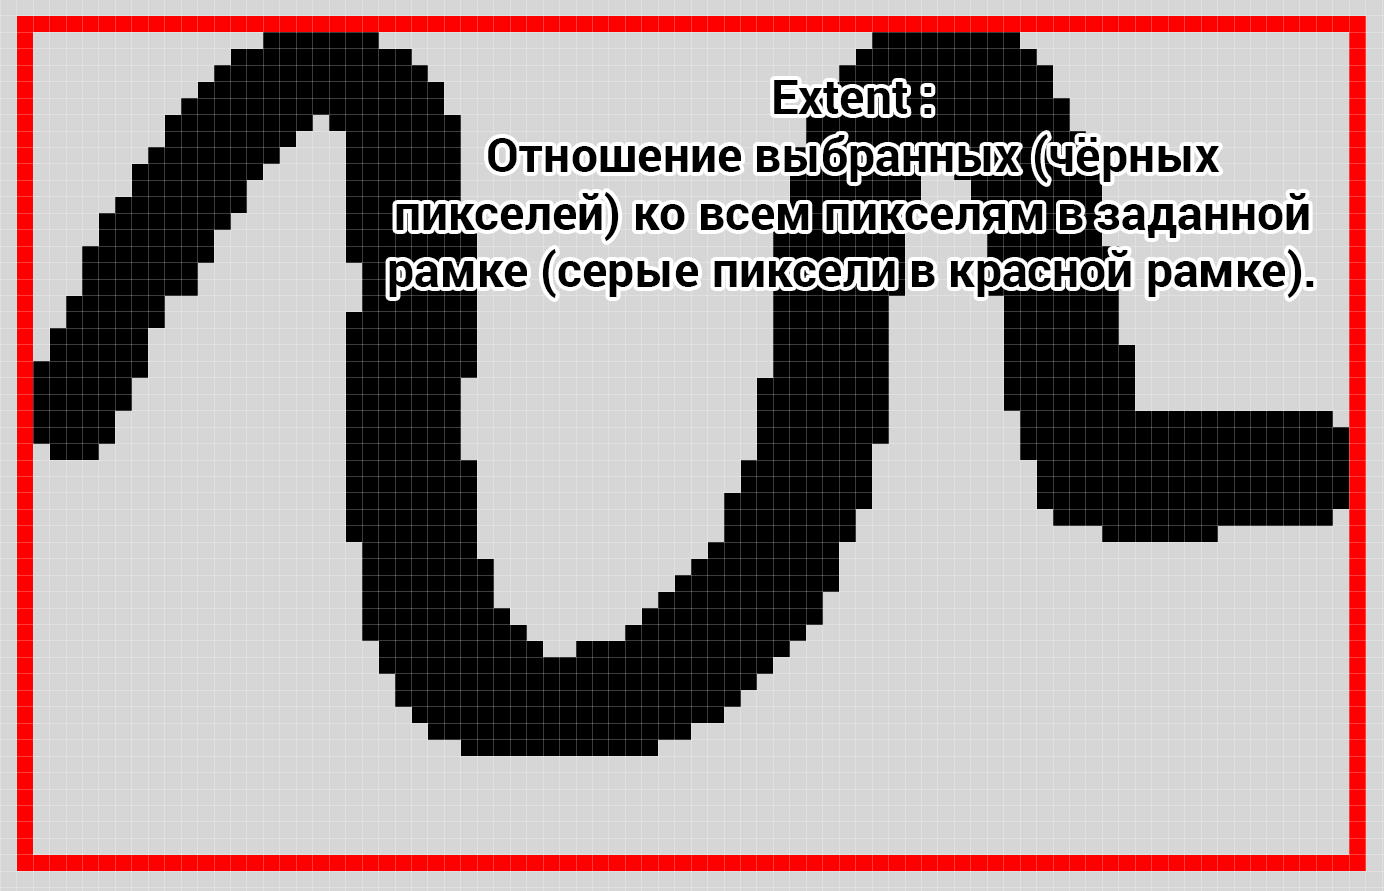

In [95]:
# Insert image to markdown

from IPython.display import Image
Image(filename="D:\Documents\Article. Benjamin\illustrations\extent.png", width=600, height=600)

In [96]:
propTabel = pd.DataFrame()
for track, index in zip(continious_tracks, tracks_id):
    prp_tbl = pd.DataFrame(measure.regionprops_table(track, properties=('bbox', 'area', 'bbox_area', 'extent')))
    prp_tbl['track_id'] = index
    propTabel = pd.concat([propTabel, prp_tbl], axis=0)
propTabel.set_index('track_id', inplace=True)
propTabel

,bbox-0,bbox-1,bbox-2,bbox-3,area,bbox_area,extent
track_id,,,,,,,
52,226,30,327,2581,130874,257651,0.507951
53,150,49,284,2571,199689,337948,0.590887
61,153,33,258,2574,149749,266805,0.561268
62,63,38,228,2557,319005,415635,0.767512
67,145,171,233,2499,111671,204864,0.545098
68,146,127,242,2532,120629,230880,0.522475
69,144,123,230,2544,139469,208206,0.669861
70,153,6,302,2559,170933,380397,0.449354
71,149,16,329,2582,316445,461880,0.685124


In [97]:
def pixel2mm(df, column_names):
    # Calculate the pixel size in mm
    koef = 10 / 2500
    for name in column_names:
        df[name] = df[name] * koef

In [98]:
def pixel2mm2(df, column_names):
    # Calculate the pixel size in mm
    koef = 10 / 2500
    for name in column_names:
        df[name] = df[name] * koef * koef

In [99]:
propTabel.columns

Index(['bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'area', 'bbox_area', 'extent'], dtype='object')

In [100]:
pixel2mm(propTabel, ['bbox-0', 'bbox-1', 'bbox-2', 'bbox-3'])
pixel2mm2(propTabel, ['area', 'bbox_area'])

In [101]:
propTabel

,bbox-0,bbox-1,bbox-2,bbox-3,area,bbox_area,extent
track_id,,,,,,,
52,0.904,0.120,1.308,10.324,2.093984,4.122416,0.507951
53,0.600,0.196,1.136,10.284,3.195024,5.407168,0.590887
61,0.612,0.132,1.032,10.296,2.395984,4.268880,0.561268
62,0.252,0.152,0.912,10.228,5.104080,6.650160,0.767512
67,0.580,0.684,0.932,9.996,1.786736,3.277824,0.545098
68,0.584,0.508,0.968,10.128,1.930064,3.694080,0.522475
69,0.576,0.492,0.920,10.176,2.231504,3.331296,0.669861
70,0.612,0.024,1.208,10.236,2.734928,6.086352,0.449354
71,0.596,0.064,1.316,10.328,5.063120,7.390080,0.685124


In [102]:
# Define the range and increments for power and speed
power_start = 40
power_stop = 400
# power_step = 45
speed_start = 2000
speed_stop = 200
# speed_step = -225

# Generate the sequences of power and speed values. So there is 11 values for power and 9 for speed
power_values = np.linspace(power_start, power_stop, 11)
speed_values = np.linspace(speed_start, speed_stop, 9)

# Create an empty 2D array with the desired shape
num_rows = len(power_values)
num_cols = len(speed_values)
print(f"Array shape: {num_rows} x {num_cols}")
tracks_tech_params = np.zeros((num_rows, num_cols), dtype=[('power', int), ('speed', int)])

# Fill the array with (power, speed) tuples
for i, power_value in enumerate(power_values):
    for j, speed_value in enumerate(speed_values):
        tracks_tech_params[i, j] = (power_value, speed_value)

# Print the resulting array
print(tracks_tech_params)
tracks_tech_params_raveled = tracks_tech_params.ravel()

Array shape: 11 x 9
[[( 40, 2000) ( 40, 1775) ( 40, 1550) ( 40, 1325) ( 40, 1100) ( 40,  875)
  ( 40,  650) ( 40,  425) ( 40,  200)]
 [( 76, 2000) ( 76, 1775) ( 76, 1550) ( 76, 1325) ( 76, 1100) ( 76,  875)
  ( 76,  650) ( 76,  425) ( 76,  200)]
 [(112, 2000) (112, 1775) (112, 1550) (112, 1325) (112, 1100) (112,  875)
  (112,  650) (112,  425) (112,  200)]
 [(148, 2000) (148, 1775) (148, 1550) (148, 1325) (148, 1100) (148,  875)
  (148,  650) (148,  425) (148,  200)]
 [(184, 2000) (184, 1775) (184, 1550) (184, 1325) (184, 1100) (184,  875)
  (184,  650) (184,  425) (184,  200)]
 [(220, 2000) (220, 1775) (220, 1550) (220, 1325) (220, 1100) (220,  875)
  (220,  650) (220,  425) (220,  200)]
 [(256, 2000) (256, 1775) (256, 1550) (256, 1325) (256, 1100) (256,  875)
  (256,  650) (256,  425) (256,  200)]
 [(292, 2000) (292, 1775) (292, 1550) (292, 1325) (292, 1100) (292,  875)
  (292,  650) (292,  425) (292,  200)]
 [(328, 2000) (328, 1775) (328, 1550) (328, 1325) (328, 1100) (328,  875)
  

In [103]:
# Assign the power and speed values to the tracks. Use track_id as index to assign the values
propTabel['power'] = tracks_tech_params_raveled[propTabel.index]['power']
propTabel['speed'] = tracks_tech_params_raveled[propTabel.index]['speed']
propTabel['flux_density'] = propTabel['power'] * propTabel['area']

propTabel

,bbox-0,bbox-1,bbox-2,bbox-3,area,bbox_area,extent,power,speed,flux_density
track_id,,,,,,,,,,
52,0.904,0.120,1.308,10.324,2.093984,4.122416,0.507951,220,425,460.676480
53,0.600,0.196,1.136,10.284,3.195024,5.407168,0.590887,220,200,702.905280
61,0.612,0.132,1.032,10.296,2.395984,4.268880,0.561268,256,425,613.371904
62,0.252,0.152,0.912,10.228,5.104080,6.650160,0.767512,256,200,1306.644480
67,0.580,0.684,0.932,9.996,1.786736,3.277824,0.545098,292,1100,521.726912
68,0.584,0.508,0.968,10.128,1.930064,3.694080,0.522475,292,875,563.578688
69,0.576,0.492,0.920,10.176,2.231504,3.331296,0.669861,292,650,651.599168
70,0.612,0.024,1.208,10.236,2.734928,6.086352,0.449354,292,425,798.598976
71,0.596,0.064,1.316,10.328,5.063120,7.390080,0.685124,292,200,1478.431040


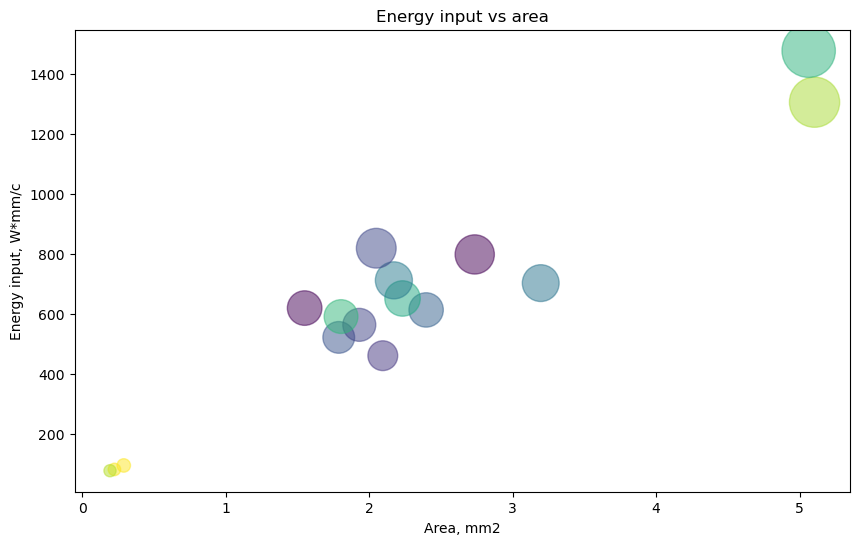

In [115]:
# Plot scatter plot of area and energy input
plt.figure(figsize=(10, 6))
plt.scatter(propTabel['area'], propTabel['flux_density'],\
            s=propTabel['flux_density'], alpha=0.5, c=propTabel['extent'])
plt.xlabel('Area, mm2')
plt.ylabel('Energy input, W*mm/c')
plt.title('Energy input vs area')
plt.show()

In [125]:
# Save the plot to html file
fig.write_html("flux_density_vs_area.html")

In [153]:
import base64
from io import BytesIO
from PIL import Image

def img_array_to_base64(img_array):
    img = Image.fromarray(img_array)
    img = img.convert('L')  # Convert the image to 8-bit grayscale
    buffer = BytesIO()
    img.save(buffer, format="PNG")
    img_str = base64.b64encode(buffer.getvalue()).decode()
    return img_str

In [154]:
propTabel['image_base64'] = [img_array_to_base64(images_cropped[i]) for i in propTabel.index]
propTabel

,bbox-0,bbox-1,bbox-2,bbox-3,area,bbox_area,extent,power,speed,flux_density,image_base64
track_id,,,,,,,,,,,
52,0.904,0.120,1.308,10.324,2.093984,4.122416,0.507951,220,425,460.676480,iVBORw0KGgoAAAANSUhEUgAACiAAAAHCCAAAAABJRcyRAA...
53,0.600,0.196,1.136,10.284,3.195024,5.407168,0.590887,220,200,702.905280,iVBORw0KGgoAAAANSUhEUgAACiAAAAHCCAAAAABJRcyRAA...
61,0.612,0.132,1.032,10.296,2.395984,4.268880,0.561268,256,425,613.371904,iVBORw0KGgoAAAANSUhEUgAACiAAAAHCCAAAAABJRcyRAA...
62,0.252,0.152,0.912,10.228,5.104080,6.650160,0.767512,256,200,1306.644480,iVBORw0KGgoAAAANSUhEUgAACiAAAAHCCAAAAABJRcyRAA...
67,0.580,0.684,0.932,9.996,1.786736,3.277824,0.545098,292,1100,521.726912,iVBORw0KGgoAAAANSUhEUgAACiAAAAHCCAAAAABJRcyRAA...
68,0.584,0.508,0.968,10.128,1.930064,3.694080,0.522475,292,875,563.578688,iVBORw0KGgoAAAANSUhEUgAACiAAAAHCCAAAAABJRcyRAA...
69,0.576,0.492,0.920,10.176,2.231504,3.331296,0.669861,292,650,651.599168,iVBORw0KGgoAAAANSUhEUgAACiAAAAHCCAAAAABJRcyRAA...
70,0.612,0.024,1.208,10.236,2.734928,6.086352,0.449354,292,425,798.598976,iVBORw0KGgoAAAANSUhEUgAACiAAAAHCCAAAAABJRcyRAA...
71,0.596,0.064,1.316,10.328,5.063120,7.390080,0.685124,292,200,1478.431040,iVBORw0KGgoAAAANSUhEUgAACiAAAAHCCAAAAABJRcyRAA...


In [165]:
import plotly.express as px
fig = px.scatter(propTabel, x='area', y='flux_density', size='flux_density', color='extent',
                 title='Energy input vs area',
                 labels={'area': 'Area, mm2', 'flux_density': 'Flux density, W*mm/c'},
                 hover_data=['image_base64', 'power', 'speed'],
                 hover_name=propTabel.index)

fig.update_traces(hovertemplate='<br>Power: %{customdata[1]} W<br>' +
                                'Speed: %{customdata[2]} mm/s<br>'+
                                'Flux density: %{y:.2f} W*mm/c<br>'+
                                'Area: %{x:2f} mm2<br>')
fig.show()
# Save the plot to html file
fig.write_html("flux_density_vs_area.html")